In [1]:
import tensorflow as tf
from tensorflow.keras import datasets,  models, losses, Model
from tensorflow.python.keras.applications.resnet import ResNet50
import tensorflow_datasets as tfds
#from Nets_original  import GetNeuralNetworkModel
from tensorflow.python.keras import backend as K
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plotter_lib
import PIL as image_lib
from tensorflow.keras.models import Sequential
import pathlib
#### Necessary Imports for Neural Net 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import os
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2

%matplotlib inline
     


In [ ]:
#La principal motivación del trabajo original de ResNet fue abordar el problema de la degradación en una red profunda.

# ResNet50

In [ ]:
#Construiremos ResNet con 50 capas. 
#La arquitectura adoptada para ResNet-50 es diferente de la arquitectura de 34 capas. La conexión de acceso directo 
#salta 3 bloques en lugar de 2 y, el siguiente diagrama esquemático nos ayudará a aclarar algunos puntos:

## a) Get Dataset

In [2]:
# Load Cifar-10 data-set
(train_im, train_lab), (test_im, test_lab) = tf.keras.datasets.cifar10.load_data()

In [3]:
train_im

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [5]:
#### Normalize the images to pixel values (0, 1)
train_im, test_im = train_im/255.0 , test_im/255.0
#### Check the format of the data 
print ("train_im, train_lab types: ", type(train_im), type(train_lab))
#### check the shape of the data
print ("shape of images and labels array: ", train_im.shape, train_lab.shape) 
print ("shape of images and labels array ; test: ", test_im.shape, test_lab.shape)
     

train_im, train_lab types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape of images and labels array:  (50000, 32, 32, 3) (50000, 1)
shape of images and labels array ; test:  (10000, 32, 32, 3) (10000, 1)


In [6]:
train_im

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

In [5]:
#### Check the distribution of unique elements 
(unique, counts) = np.unique(train_lab, return_counts=True)

frequencies = np.asarray((unique, counts)).T

print (frequencies)
print (len(unique))
     

[[   0 5000]
 [   1 5000]
 [   2 5000]
 [   3 5000]
 [   4 5000]
 [   5 5000]
 [   6 5000]
 [   7 5000]
 [   8 5000]
 [   9 5000]]
10


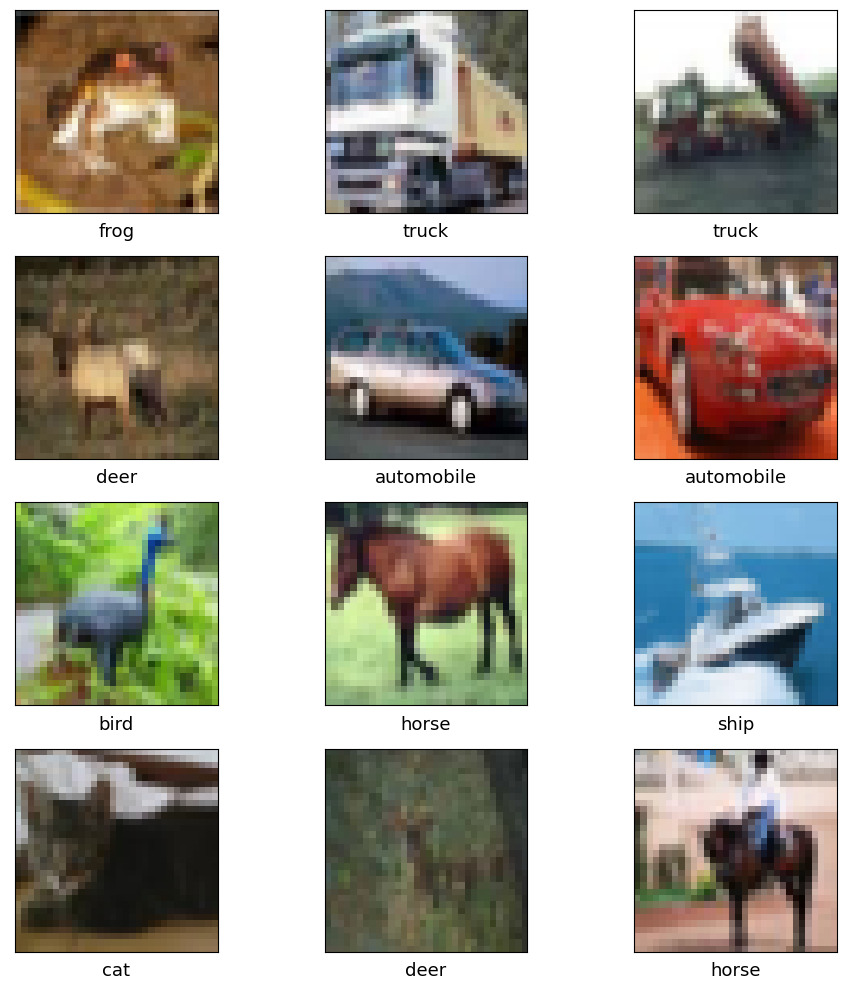

In [6]:
class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'] # from cifar-10 website

plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_im[i], cmap='gray')
    plt.xlabel(class_types[train_lab[i][0]], fontsize=13)
plt.tight_layout()    
plt.show()

In [7]:
### One hot encoding for labels 

train_lab_categorical = tf.keras.utils.to_categorical(   train_lab, num_classes=10, dtype='uint8')

test_lab_categorical = tf.keras.utils.to_categorical(    test_lab, num_classes=10, dtype='uint8')

In [8]:
### Train -test split 

from sklearn.model_selection import train_test_split 
train_im, valid_im, train_lab, valid_lab = train_test_split(train_im, train_lab_categorical, test_size=0.20, 
                                                            stratify=train_lab_categorical, 
                                                            random_state=40, shuffle = True)

print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

train data shape after the split:  (40000, 32, 32, 3)
new validation data shape:  (10000, 32, 32, 3)
validation labels shape:  (10000, 10)


In [9]:
##### Include Little Data Augmentation 
batch_size = 64 # try several values

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, width_shift_range=0.1, height_shift_range = 0.1, 
                                                                horizontal_flip=True)
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_DataGen.flow(train_im, train_lab, batch_size=batch_size) # train_lab is categorical 
valid_set_conv = valid_datagen.flow(valid_im, valid_lab, batch_size=batch_size) # so as valid_lab 

##  Bloque identidad

In [10]:
def res_identity(x, filters): 
    ''' renet block where dimension doesnot change.
    The skip connection is just simple identity conncection
    we will have 3 blocks and then input will be added
    '''
    x_skip = x # this will be used for addition with the residual block 
    f1, f2 = filters

    #first block 
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)


    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)


    # third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # x = Activation(activations.relu)(x)

    # add the input 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

## Bloque Residual 
 

In [ ]:
#Bloque Residual: La formulación de aprendizaje residual asegura que cuando las asignaciones de identidad son óptimas 
#(es decir, g(x) = x ), la optimización conducirá los pesos hacia cero de la función residual.
#ResNet consta de muchos bloques residuales donde el aprendizaje residual se adopta cada pocas capas apiladas (generalmente
#2 o 3 capas). El bloque de construcción se muestra en la Figura 2 y el resultado final se puede considerar como 
#y = f(x, W) + x . Aquí W son los pesos y estos se aprenden durante el entrenamiento. La operación f + x se realiza
#mediante una conexión de atajo ('saltar' 2/3 capas) y una suma de elementos. Este es el bloque más simple donde no hay 
#parámetros adicionales involucrados en la conexión de salto. La suma de elementos solo es posible cuando las dimensiones 
#de f y x son iguales, si este no es el caso, multiplicamos la entrada x por una matriz de proyección Ws, de modo que las 
#dimensiones de f y x coincidan. En este caso, la salida cambiará de la ecuación anterior a y = f(x, W) + Ws * x . 
#Los elementos en la matriz de proyección también serán entrenables. 

In [11]:
def res_conv(x, s, filters):
    
#here the input size changes, when it goes via conv blocks  so the skip connection uses a projection (conv layer) matrix  ''' 
    x_skip = x
    f1, f2 = filters

    # first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
    # when s = 2 then it is like downsizing the feature map
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
#   x = AddCustomLayers(x,include_aging=True,aging_active = aging_active[blockId])    
    

    # second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
#    x = AddCustomLayers(x,include_aging=True,aging_active = aging_active[blockId+1])

    #third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # shortcut 
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)
#   x = AddCustomLayers(x,include_aging=False)
    # add 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)
    

    return x
     

## Modelo completo

In [12]:


### Combine the above functions to build 50 layers resnet. 
def resnet50():
    input_im = Input(shape=(train_im.shape[1], train_im.shape[2], train_im.shape[3])) # cifar 10 images size
#   x = AddCustomLayers(input_layer,include_aging=True,aging_active = aging_active[0])
    x = ZeroPadding2D(padding=(3, 3))(input_im)

    # 1st stage
    # here we perform maxpooling, see the figure above

    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
#   x = AddCustomLayers(x,include_aging=False)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
#   x = AddCustomLayers(x,include_aging=True,aging_active = aging_active[1])    
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #2nd stage 
    # frm here on only conv block and identity block, no pooling

    x = res_conv(x, s=1, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))

    # 3rd stage

    x = res_conv(x, s=2, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))

    # 4th stage

    x = res_conv(x, s=2, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))

    # 5th stage

    x = res_conv(x, s=2, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))

    # ends with average pooling and dense connection

    x = AveragePooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')(x) #multi-class

    # define the model 

    model = Model(inputs=input_im, outputs=x, name='Resnet50')

    return model
       


In [13]:
### Define some Callbacks
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr
  # if epoch < 40:
  #   return 0.01
  # else:
  #   return 0.01 * np.math.exp(0.03 * (40 - epoch))
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  


def earlystop(mode):
    if mode=='acc':
        estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
    elif mode=='loss':
        estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
    return estop    

In [14]:
resnet50_model = resnet50()

In [15]:
resnet50_model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
___________________________________________________________________________________________

In [16]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

In [ ]:
#Usando un tamaño de lote de 64, 160 épocas y aumento de datos, se logró una precisión de ∼ 85 % en datos de entrenamiento 
#y ∼ 82 % en datos de prueba.
#A continuación se muestran las curvas de entrenamiento y validación: 

In [17]:
batch_size=batch_size # test with 64, 128, 256

resnet_train = resnet50_model.fit(train_set_conv,  epochs=160,  steps_per_epoch=train_im.shape[0]/batch_size, 
                                  validation_steps=valid_im.shape[0]/batch_size,  validation_data=valid_set_conv, 
                                  callbacks=[lrdecay])
     

Epoch 1/160


KeyboardInterrupt: 

In [ ]:
### Plot train and validation curves
loss = resnet_train.history['loss']
v_loss = resnet_train.history['val_loss']

acc = resnet_train.history['acc']
v_acc = resnet_train.history['val_acc']

epochs = range(len(loss))

fig = plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/train_acc.png', dpi=250)
plt.show()

# d) Load/Save Weigths

In [ ]:
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
AlexNet.load_weights(wgt_dir)

In [ ]:
(OrigLoss,OrigAcc) = AlexNet.evaluate(test_set)

# 3) Quantization 

In [ ]:
### Definir parte entera  y parte fraccionaria para activaciones y pesos 

In [ ]:
df = QuantizationEffect('AlexNet',test_set,wgt_dir,(227,227,3),8,test_batch_size)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Number of bits analysis

In [ ]:
CheckAccuracyAndLoss('AlexNet', test_set, wgt_dir, act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4, 
                    input_shape = (227,227,3), output_shape = 8, batch_size = test_batch_size);

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  c) Activation Stats

In [ ]:
ActivationStats(AlexNet,test_set,11,4,24)